# Classes and functions from FairSMOTE

In [ ]:
from __future__ import print_function, division
import pdb
import unittest
import random
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors as NN

class smote(object):
  def __init__(self, pd_data, neighbor=5,r=2 ,up_to_num=[],auto=True):
    """
    :param pd_data: panda.DataFrame, the last column must be class label
    :param neighbor: num of nearst neighbors to select
    :param up_to_num: size of minorities to over-sampling
    :param up_to_max: if up_to_num is not supplied, all minority classes will
                      be over-sampled as much as majority class
    :return panda.DataFrame smoted data
    """
    self.set_data(pd_data)
    self.auto = auto
    self.neighbor = neighbor
    self.up_to_max = False
    self.up_to_num = up_to_num
    self.r = r
    self.label_num = len(set(pd_data[pd_data.columns[-1]].values))
    #if up_to_num:
    #  label_num = len(set(pd_data[pd_data.columns[-1]].values))
    #  if label_num - 1 != len(up_to_num):
    #    raise ValueError(
    #      "should set smoted size for " + str(label_num - 1) + " minorities")
    #  self.up_to_num = up_to_num
    #else:
    #  self.up_to_max = True

  def set_data(self, pd_data):
    if not pd_data.empty:# and isinstance(
        #pd_data.ix[:, pd_data.columns[-1]].values[0], str):
      self.data = pd_data
    else:
      raise ValueError(
        "The last column of pd_data should be string as class label")

  def get_majority_num(self):
    total_data = self.data.values.tolist()
    labelCont = Counter(self.data[self.data.columns[-1]].values)
    majority_num = max(labelCont.values())
    return majority_num

  def run(self):
    """
    run smote
    """

    def get_ngbr(data_no_label, knn):
      rand_sample_idx = random.randint(0, len(data_no_label) - 1)
      rand_sample = data_no_label[rand_sample_idx]
      distance, ngbr = knn.kneighbors(rand_sample.reshape(1, -1))
      # while True:
      rand_ngbr_idx = random.randint(0, len(ngbr))
      #   if distance[rand_ngbr_idx] == 0:
      #     continue  # avoid the sample itself, where distance ==0
      #   else:
      return data_no_label[rand_ngbr_idx], rand_sample

    total_data = self.data.values.tolist()
    labelCont = Counter(self.data[self.data.columns[-1]].values)
    majority_num = max(labelCont.values())
    for label, num in labelCont.items():
      if num < majority_num:
        to_add = majority_num - num
        last_column = self.data[self.data.columns[-1]]
        data_w_label = self.data.loc[last_column == label]
        data_no_label = data_w_label[self.data.columns[:-1]].values
        if len(data_no_label) < self.neighbor:
          num_neigh = len(data_no_label) # void # of neighbors >= sample size
        else:
          num_neigh = self.neighbor
        knn = NN(n_neighbors=num_neigh,p=self.r,algorithm='ball_tree').fit(data_no_label)
        if self.auto:
          to_add = to_add
        else:
          to_add = self.up_to_num
        for _ in range(to_add):
          rand_ngbr, sample = get_ngbr(data_no_label, knn)
          new_row = []
          for i, one in enumerate(rand_ngbr):
            gap = random.random()
            new_row.append(max(0, sample[i] + (
            sample[i] - one) * gap))  # here, feature vlaue should >=0
          new_row.append(label)
          total_data.append(new_row)
    return pd.DataFrame(total_data)

In [ ]:
from __future__ import print_function, division
import pdb
import unittest
import random
from collections import Counter
import pandas as pd
import numpy as np
from scipy.spatial import distance as dist
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors as NN

def get_ngbr(df, knn):
            rand_sample_idx = random.randint(0, df.shape[0] - 1)
            parent_candidate = df.iloc[rand_sample_idx]
            ngbr = knn.kneighbors(parent_candidate.values.reshape(1,-1),3,return_distance=False)
            candidate_1 = df.iloc[ngbr[0][0]]
            candidate_2 = df.iloc[ngbr[0][1]]
            candidate_3 = df.iloc[ngbr[0][2]]
            return parent_candidate,candidate_2,candidate_3

def generate_samples(no_of_samples,df,df_name):

    total_data = df.values.tolist()
    knn = NN(n_neighbors=5,algorithm='auto').fit(df)

    for _ in range(no_of_samples):
        cr = 0.8
        f = 0.8
        parent_candidate, child_candidate_1, child_candidate_2 = get_ngbr(df, knn)
        new_candidate = []
        for key,value in parent_candidate.items():
            if isinstance(parent_candidate[key], bool):
                new_candidate.append(parent_candidate[key] if cr < random.random() else not parent_candidate[key])
            elif isinstance(parent_candidate[key], str):
                new_candidate.append(random.choice([parent_candidate[key],child_candidate_1[key],child_candidate_2[key]]))
            elif isinstance(parent_candidate[key], list):
                temp_lst = []
                for i, each in enumerate(parent_candidate[key]):
                    temp_lst.append(parent_candidate[key][i] if cr < random.random() else
                                    int(parent_candidate[key][i] +
                                        f * (child_candidate_1[key][i] - child_candidate_2[key][i])))
                new_candidate.append(temp_lst)
            else:
                new_candidate.append(abs(parent_candidate[key] + f * (child_candidate_1[key] - child_candidate_2[key])))
        total_data.append(new_candidate)

    final_df = pd.DataFrame(total_data)
    if df_name == 'Adult':
        final_df = final_df.rename(columns={0:"age",1:"education.num",2:"race",3:"sex",4:"capital.gain",5:"capital.loss",6:"hours.per.week",7:"income"}, errors="raise")
    if df_name == 'Compas':
        final_df = final_df.rename(columns={0:"sex",1:"age_cat",2:"race",3:"priors_count",4:"c_charge_degree",5:"Probability"}, errors="raise")
    if df_name == 'Default':
    	final_df = final_df.rename(columns={0:"ID",1:"LIMIT_BAL",2:"sex",3:"EDUCATION",4:"MARRIAGE",5:"AGE",6:"PAY_0",7:"PAY_2",8:"PAY_3",9:"PAY_4",10:"PAY_5",11:"PAY_6",12:"BILL_AMT1",13:"BILL_AMT2",14:"BILL_AMT3",15:"BILL_AMT4",16:"BILL_AMT5",17:"BILL_AMT6",18:"PAY_AMT1",19:"PAY_AMT2",20:"PAY_AMT3",21:"PAY_AMT4",22:"PAY_AMT5",23:"PAY_AMT6",24:"Probability"}, errors="raise")
    if df_name == 'German':
    	final_df = final_df.rename(columns={0:"Age",1:"Sex",2:"Job",3:"Credit_amount",4:"Duration",5:"young",6:"Housing_free",7:"Housing_own",8:"Housing_rent",9:"Saving_accounts_little",10:"Saving_accounts_moderate",11:"Saving_accounts_rich",12:"Checking_account_little",13:"Checking_account_moderate",14:"Checking_account_rich",15:"Risk"}, errors="raise")
                          #  feature_columns = ['Age', 'Sex', 'Job', 'Credit_amount', 'Duration', 'young','Housing_free', 'Housing_own', 'Housing_rent', 'Saving_accounts_little', 'Saving_accounts_moderate','Saving_accounts_rich', 'Checking_account_little','Checking_account_moderate', 'Checking_account_rich']

    if df_name == 'diabetes':
        final_df = final_df.rename(columns={0:'gender', 1:'age', 2:'bmi', 3:'HbA1c_level', 4:'blood_glucose_level', 5:'hypertension_0', 6:'hypertension_1',
       7:'heart_disease_0', 8:'heart_disease_1', 9:'smoking_history_No Info', 10:'smoking_history_current', 11:'smoking_history_ever', 12:'smoking_history_former',
       13:'smoking_history_never', 14:'smoking_history_not current', 15:'diabetes'}, errors="raise")


    if df_name == 'Heart':
    	final_df = final_df.rename(columns={0:"age",1:"sex",2:"cp",3:"trestbps",4:"chol",5:"fbs",6:"restecg",7:"thalach",8:"exang",9:"oldpeak",10:"slope",11:"ca",12:"thal",13:"Probability"}, errors="raise")
    if df_name == 'Bank':
        final_df = final_df.rename(columns={0:"age",1:"default",2:"balance",3:"housing",4:"loan",5:"day",6:"duration",7:"campaign",8:"pdays",9:"previous",10:"Probability"}, errors="raise")
    if df_name == 'Titanic':
        final_df = final_df.rename(columns={0:"Pclass",1:"sex",2:"Age",3:"SibSp",4:"Parch",5:"Fare",6:"Probability"}, errors="raise")
    if df_name == 'Student':
        final_df = final_df.rename(columns={0:'sex', 1:'age', 2:'Medu', 3:'Fedu', 4:'traveltime', 5:'studytime', 6:'failures',
       7:'schoolsup', 8:'famsup', 9:'paid', 10:'activities', 11:'nursery', 12:'higher',
       13:'internet', 14:'romantic', 15:'famrel', 16:'freetime', 17:'goout', 18:'Dalc', 19:'Walc',
       20:'health', 21:'absences', 22:'G1', 23:'G2', 24:'Probability'}, errors="raise")


    return final_df

In [ ]:
import time
import pandas as pd
import random,time,csv
import numpy as np
import math,copy,os
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics


import sys
sys.path.append(os.path.abspath('..'))
from imblearn import under_sampling, over_sampling

# from SMOTE import smote
# from imblearn.over_sampling import SMOTE

# from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy
# from Generate_Samples import generate_samples



!pip uninstall numpy
!pip install numpy
! pip install ctgan
! pip install --upgrade category_encoders


# ! pip install table_evaluator

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime
import pprint
import json



Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.23.5.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? 

In [ ]:
# Record the start time
start_time = time.time()

# Load Dataset

In [ ]:
# ## Load dataset
# from sklearn import preprocessing
# dataset_orig = pd.read_csv('../data/adult.data.csv')

# ## Drop NULL values
# dataset_orig = dataset_orig.dropna()

# ## Drop categorical features
# dataset_orig = dataset_orig.drop(['workclass','fnlwgt','education','marital-status','occupation','relationship','native-country'],axis=1)

# ## Change symbolics to numerics
# dataset_orig['sex'] = np.where(dataset_orig['sex'] == ' Male', 1, 0)
# dataset_orig['race'] = np.where(dataset_orig['race'] != ' White', 0, 1)
# dataset_orig['Probability'] = np.where(dataset_orig['Probability'] == ' <=50K', 0, 1)


# ## Discretize age
# dataset_orig['age'] = np.where(dataset_orig['age'] >= 70, 70, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 60 ) & (dataset_orig['age'] < 70), 60, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 50 ) & (dataset_orig['age'] < 60), 50, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 40 ) & (dataset_orig['age'] < 50), 40, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 30 ) & (dataset_orig['age'] < 40), 30, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 20 ) & (dataset_orig['age'] < 30), 20, dataset_orig['age'])
# dataset_orig['age'] = np.where((dataset_orig['age'] >= 10 ) & (dataset_orig['age'] < 10), 10, dataset_orig['age'])
# dataset_orig['age'] = np.where(dataset_orig['age'] < 10, 0, dataset_orig['age'])

# protected_attribute = 'race'

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# dataset_orig = pd.DataFrame(scaler.fit_transform(dataset_orig),columns = dataset_orig.columns)


# dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2,shuffle = True)

# # dataset_orig

## Fairness metrics and functions


In [ ]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    ,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

In [ ]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    print('bias metrics:')
    print('equal opportunity for tpr: (close to 0)', op_diff)
    print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    print('avarage absolute odds difference: (close to 0)',od_diff)
    print('statistical parity difference: (close to 0) ',par_diff)
    print('disparate_impact: (close to 1) ',dis_impact)

#     # Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Bar colors
#     colors = ['blue', 'orange']

#     # Plot 1 - orig_data_one_priv and orig_data_one_non_priv
#     axs[0].bar(['priv', 'non_priv'], [tpr_0, tpr_1], color=colors)
#     axs[0].set_xlabel('Data Type')
#     axs[0].set_ylabel('Count')
#     axs[0].set_title('TPR(maximize)')

#     # Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
#     axs[1].bar(['priv', 'non_priv'], [fpr_0, fpr_1], color=colors)
#     axs[1].set_xlabel('Data Type')
#     axs[1].set_ylabel('Count')
#     axs[1].set_title('FPR(minimize)')

#     # Adjust spacing between subplots
#     plt.subplots_adjust(wspace=0.4)

#     # Show the plots
#     plt.show()

    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [ ]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [ ]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [ ]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

## Datasets & Params¶


In [ ]:
# choose dataset
#DATASET_NAME = 'ADULT_SEX'
#DATASET_NAME = 'ADULT_RACE'
#DATASET_NAME ='COMPAS_RACE_AM'
#DATASET_NAME = 'COMPAS_SEX'
# DATASET_NAME='CREDIT_SEX'
DATASET_NAME = 'DIABETES_SEX'

#DATASET_NAME = 'BANK_AGE'


In [ ]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!mkdir /root/.kaggle/
# Installing the Kaggle package
!pip install kaggle

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"guyrozenblatt","key":"e2ba3aff97edbcc7b8ab392e91dd8c65"}


# creating kaggle.json file with the personal API-Key details
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json


!mkdir ./datasets/compastwoyears/compas-scores-two-years_v1.csv

Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset (2).csv
User uploaded file "diabetes_prediction_dataset (2).csv" with length 3810356 bytes
mv: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mkdir: cannot create directory ‘./datasets/compastwoyears/compas-scores-two-years_v1.csv’: No such file or directory


In [ ]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['race'] = np.where(orig_data['race'] != 'White', 0, 1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'education.num','race', 'sex', 'capital.gain','capital.loss', 'hours.per.week']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = 'race'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    print(orig_data)
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['race'] = np.where(orig_data['race'] != 'White', 0, 1)

    # orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    # feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
    #    'marital.status', 'occupation', 'relationship', 'race', 'sex',
    #    'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']
    feature_columns = ['age', 'education.num','race', 'sex', 'capital.gain','capital.loss', 'hours.per.week']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('../input/compastwoyears/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('/content/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    orig_data = orig_data.drop(columns=['Purpose'])
    orig_data = orig_data.rename(columns={"Saving accounts": "Saving_accounts", "Checking account": "Checking_account","Credit amount":"Credit_amount"})
    CATEGORICAL = ['Housing', 'Saving_accounts' , 'Checking_account']
    feature_columns = ['Age', 'Sex', 'Job', 'Credit_amount', 'Duration', 'young','Housing_free', 'Housing_own', 'Housing_rent', 'Saving_accounts_little', 'Saving_accounts_moderate','Saving_accounts_rich', 'Checking_account_little','Checking_account_moderate', 'Checking_account_rich']

    orig_data = pd.get_dummies(orig_data, columns=CATEGORICAL)
    print(orig_data.columns)



elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/kaggle/input/bank-marketing-dataset/bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']


elif DATASET_NAME == "DIABETES_SEX":
    orig_data = pd.read_csv('/content/diabetes_prediction_dataset.csv')
    TARGET_COL = 'diabetes'
    PRIV_FEATURE = 'gender'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0
    orig_data = orig_data[orig_data['gender'] != 'Other']
    orig_data['gender'] = np.where(orig_data['gender'] == 'Male', 0,1)

    feature_columns = ['gender', 'age', 'bmi', 'HbA1c_level', 'blood_glucose_level',
      'hypertension_0', 'hypertension_1', 'heart_disease_0',
       'heart_disease_1', 'smoking_history_No Info', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current']
    CATEGORICAL = ['hypertension', 'heart_disease', 'smoking_history']
    orig_data = pd.get_dummies(orig_data, columns=CATEGORICAL)


In [ ]:
orig_data

,gender,age,bmi,HbA1c_level,blood_glucose_level,diabetes,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1,80.0,25.19,6.6,140,0,1,0,0,1,0,0,0,0,1,0
1,1,54.0,27.32,6.6,80,0,1,0,1,0,1,0,0,0,0,0
2,0,28.0,27.32,5.7,158,0,1,0,1,0,0,0,0,0,1,0
3,1,36.0,23.45,5.0,155,0,1,0,1,0,0,1,0,0,0,0
4,0,76.0,20.14,4.8,155,0,0,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,80.0,27.32,6.2,90,0,1,0,1,0,1,0,0,0,0,0
99996,1,2.0,17.37,6.5,100,0,1,0,1,0,1,0,0,0,0,0
99997,0,66.0,27.83,5.7,155,0,1,0,1,0,0,0,0,1,0,0
99998,1,24.0,35.42,4.0,100,0,1,0,1,0,0,0,0,0,1,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler



# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]

scaler = MinMaxScaler()
orig_data = pd.DataFrame(scaler.fit_transform(orig_data),columns = orig_data.columns)
# # data = data[feature_columns]
# encoder = ce.TargetEncoder(cols=CATEGORICAL)

# encoder.fit(orig_data, y_orig)
# orig_data_encoded = encoder.transform(orig_data)

In [ ]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)

In [ ]:
y_orig

0        0
1        0
2        0
3        0
4        0
        ..
99977    0
99978    0
99979    0
99980    0
99981    0
Name: diabetes, Length: 99982, dtype: int64

# Check original scores

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[18297     0]
 [  588  1112]] 
accuracy:  0.9705955893384007 precision:  1.0 recall:  0.6541176470588236 fpr:  0.0 tpr:  0.6541176470588236 fn+fp 588
performance for 0 sub-group:
conf matrix:
  [[10794     0]
 [  307   587]] 
accuracy:  0.9737337440109514 precision:  1.0 recall:  0.656599552572707 fpr:  0.0 tpr:  0.656599552572707 fn+fp 307
performance for 1 sub-group:
conf matrix:
  [[7503    0]
 [ 281  525]] 
accuracy:  0.9661812492478036 precision:  1.0 recall:  0.6513647642679901 fpr:  0.0 tpr:  0.6513647642679901 fn+fp 281
bias metrics:
equal opportunity for tpr: (close to 0) 0.005234788304716909
equal opportunity for fpr: (close to 0) 0.0
avarage absolute odds difference: (close to 0) 0.0026173941523584543
statistical parity difference: (close to 0)  0.05575539568345328
disparate_impact: (close to 1)  0.4222558920495631
performance for whole ds:subexperiment - baseline Ensemble model:1
conf matrix:

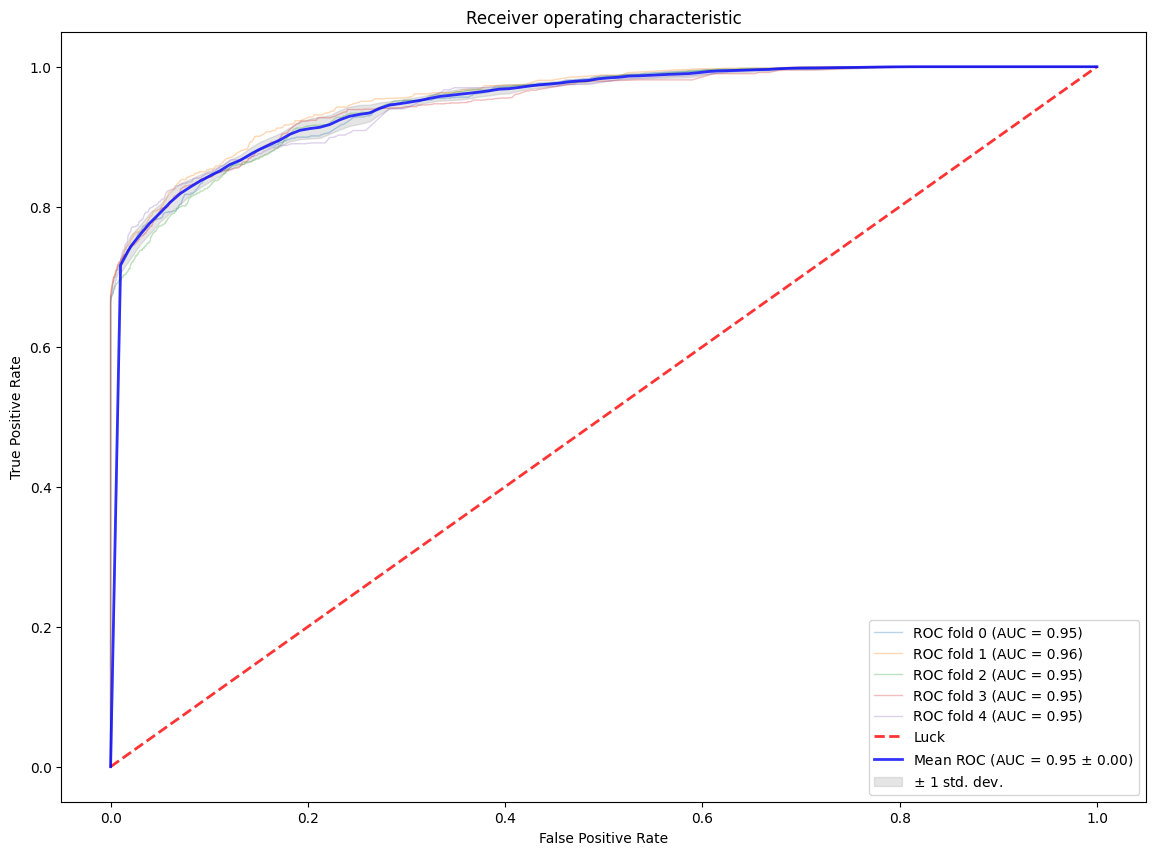

Accaracy list :  [0.9705955893384007, 0.972145821873281, 0.9648429685937188, 0.9719943988797759, 0.9710942188437688]
equal opportunity for tpr :  [0.005234788304716909, 0.010824934677118314, 0.017177524210748363, 0.003631444427811936, 0.01024581342287656]
equal opportunity for fpr :  [0.0, 0.0, 0.0, 0.0, 0.0]
odds difference list :  [0.0026173941523584543, 0.005412467338559157, 0.008588762105374181, 0.001815722213905968, 0.00512290671143828]
The mean accuracy is  0.970 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.009 ± 0.005
The mean equal opportunity for fpr: (close to 0) 0.000 ± 0.000
The mean odds difference: (close to 0) 0.005 ± 0.002
The mean parity difference: (close to 0) 0.054 ± 0.008
The mean disperate impact: (close to 1) 0.436 ± 0.018


In [ ]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data, y_orig)

In [ ]:
# X_train, y_train = dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
# X_test , y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']

# clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR

# print("recall :", measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'recall'))
# print("far :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'far'))
# print("precision :", measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'precision'))
# print("accuracy :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'accuracy'))
# print("F1 Score :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'F1'))
# print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
# print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))

# print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
# print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

# Find Class & Protected attribute Distribution

In [ ]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_dataset.groupby(orig_dataset[TARGET_COL] == 0)]

#Based on priv 1
one_one_df, one_zero_df = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] == 1)]
zero_one_df, zero_zero_df = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] == 1)]

one_one = one_one_df.shape[0]
one_zero = one_zero_df.shape[0]
zero_one = zero_one_df.shape[0]
zero_zero = zero_zero_df.shape[0]

print(zero_zero,zero_one,one_zero,one_one)

54091 37391 4461 4039


# Sort these four

In [ ]:
maximum = max(zero_zero,zero_one,one_zero,one_one)
if maximum == zero_zero:
    print("zero_zero is maximum")
if maximum == zero_one:
    print("zero_one is maximum")
if maximum == one_zero:
    print("one_zero is maximum")
if maximum == one_one:
    print("one_one is maximum")

zero_zero is maximum


In [ ]:
zero_zero_to_be_incresed = maximum - zero_zero ## where both are 0
one_zero_to_be_incresed = maximum - one_zero ## where class is 1 attribute is 0
zero_one_to_be_incresed = maximum - zero_one ## where class is 1 attribute is 1
one_one_to_be_incresed = maximum - one_one ## where class is 1 attribute is 1


print(zero_zero_to_be_incresed,one_zero_to_be_incresed,zero_one_to_be_incresed, one_one_to_be_incresed)

0 49630 16700 50052


In [ ]:
zero_zero_df = generate_samples(zero_zero_to_be_incresed,zero_zero_df,'diabetes')
one_zero_df = generate_samples(one_zero_to_be_incresed,one_zero_df,'diabetes')
zero_one_df = generate_samples(zero_one_to_be_incresed,zero_one_df,'diabetes')
one_one_df = generate_samples(one_one_to_be_incresed,one_one_df,'diabetes')

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.p

# Append the dataframes

In [ ]:
Upsampled_Dataset = pd.concat([zero_zero_df, zero_one_df, one_zero_df, one_one_df], ignore_index=True)
Upsampled_Dataset = Upsampled_Dataset.reset_index()



In [ ]:
Upsampled_Dataset
# Upsampled_Dataset[TARGET_COL] = Upsampled_Dataset[TARGET_COL].astype(int)

,index,gender,age,bmi,HbA1c_level,blood_glucose_level,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,diabetes
0,0,1.0,1.000000,0.177171,0.563636,0.272727,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,1.0,0.674675,0.202031,0.563636,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,0.449449,0.156863,0.272727,0.340909,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,0.249249,0.202031,0.563636,0.022727,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,1.0,0.987487,0.161648,0.400000,0.022727,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216359,216359,0.0,0.424424,0.399066,0.443636,0.190909,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
216360,216360,0.0,0.406907,0.301587,0.650909,0.186364,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
216361,216361,0.0,0.754755,0.302124,0.854545,0.381818,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
216362,216362,0.0,0.954955,0.273389,0.389091,0.363636,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
y_upsampled = Upsampled_Dataset[TARGET_COL]
Upsampled_df_features = Upsampled_Dataset.loc[:, feature_columns]


In [ ]:
y_upsampled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
216359    1.0
216360    1.0
216361    1.0
216362    1.0
216363    1.0
Name: diabetes, Length: 216364, dtype: float64

In [ ]:
Upsampled_df_features

,gender,age,bmi,HbA1c_level,blood_glucose_level,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.0,1.000000,0.177171,0.563636,0.272727,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.674675,0.202031,0.563636,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.449449,0.156863,0.272727,0.340909,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.249249,0.202031,0.563636,0.022727,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.987487,0.161648,0.400000,0.022727,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216359,0.0,0.424424,0.399066,0.443636,0.190909,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
216360,0.0,0.406907,0.301587,0.650909,0.186364,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
216361,0.0,0.754755,0.302124,0.854545,0.381818,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
216362,0.0,0.954955,0.273389,0.389091,0.363636,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Check score after oversampling

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[19162  2475]
 [ 2169 19467]] 
accuracy:  0.8926813486469624 precision:  0.8872026251025431 recall:  0.8997504159733777 fpr:  0.11438739196746314 tpr:  0.8997504159733777 fn+fp 4644
performance for 0 sub-group:
conf matrix:
  [[9762 1094]
 [1177 9639]] 
accuracy:  0.8952104097452934 precision:  0.8980713686760459 recall:  0.8911797337278107 fpr:  0.10077376565954312 tpr:  0.8911797337278107 fn+fp 2271
performance for 1 sub-group:
conf matrix:
  [[9400 1381]
 [ 992 9828]] 
accuracy:  0.8901439748159807 precision:  0.8767954322419484 recall:  0.9083179297597043 fpr:  0.12809572395881644 tpr:  0.9083179297597043 fn+fp 2373
bias metrics:
equal opportunity for tpr: (close to 0) 0.017138196031893593
equal opportunity for fpr: (close to 0) 0.027321958299273322
avarage absolute odds difference: (close to 0) 0.022230077165583458
statistical parity difference: (close to 0)  0.021693555737854364
disparate_impact: (

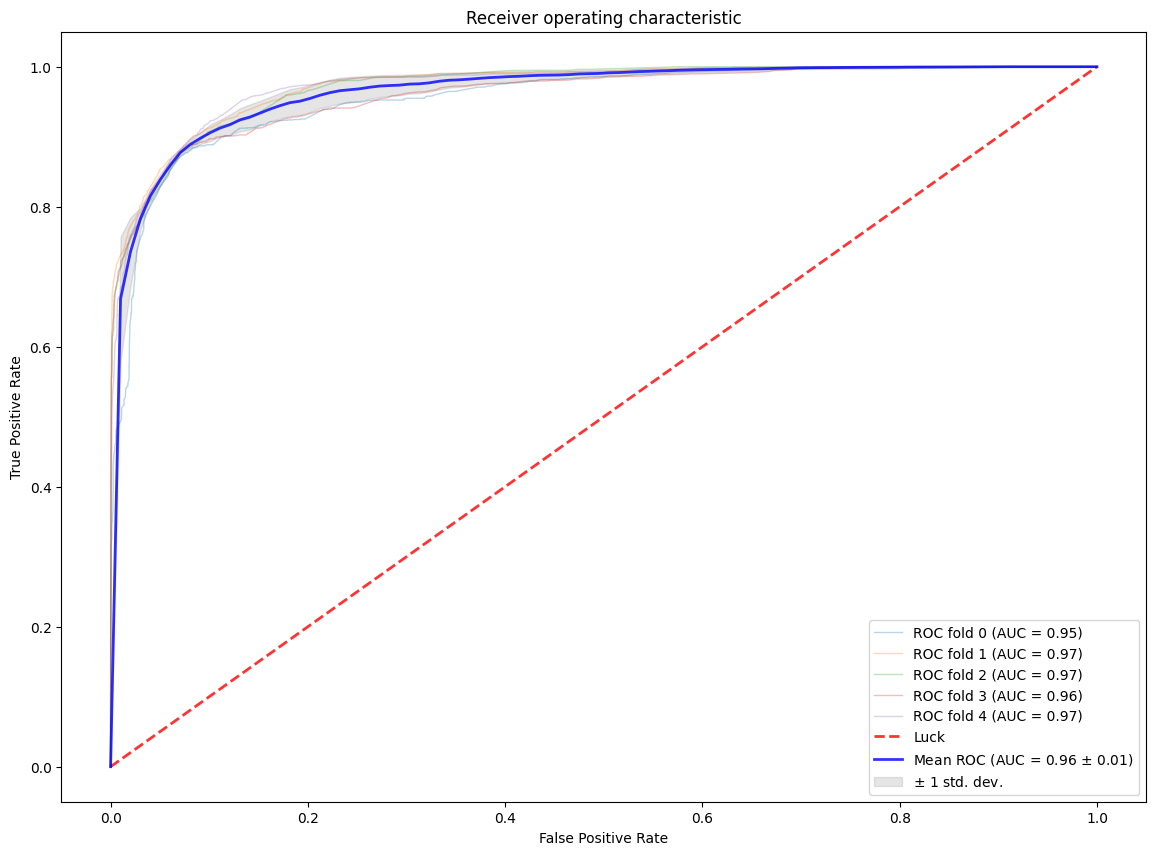

Accaracy list :  [0.8926813486469624, 0.9051140433988861, 0.9018787696716197, 0.9016476786911007, 0.9082085413200222]
equal opportunity for tpr :  [0.017138196031893593, 0.003332809727713437, 0.007416817053913838, 0.004863373032646279, 0.013879725553942013]
equal opportunity for fpr :  [0.027321958299273322, 0.0004575328168438253, 0.019468432588506494, 0.02486670083985809, 0.01741809874257781]
odds difference list :  [0.022230077165583458, 0.0018951712722786312, 0.013442624821210166, 0.014865036936252185, 0.015648912148259912]
The mean accuracy is  0.902 ± 0.005
The mean equal opportunity for tpr: (close to 0) 0.009 ± 0.005
The mean equal opportunity for fpr: (close to 0) 0.018 ± 0.009
The mean odds difference: (close to 0) 0.014 ± 0.007
The mean parity difference: (close to 0) 0.012 ± 0.007
The mean disperate impact: (close to 1) 0.494 ± 0.003


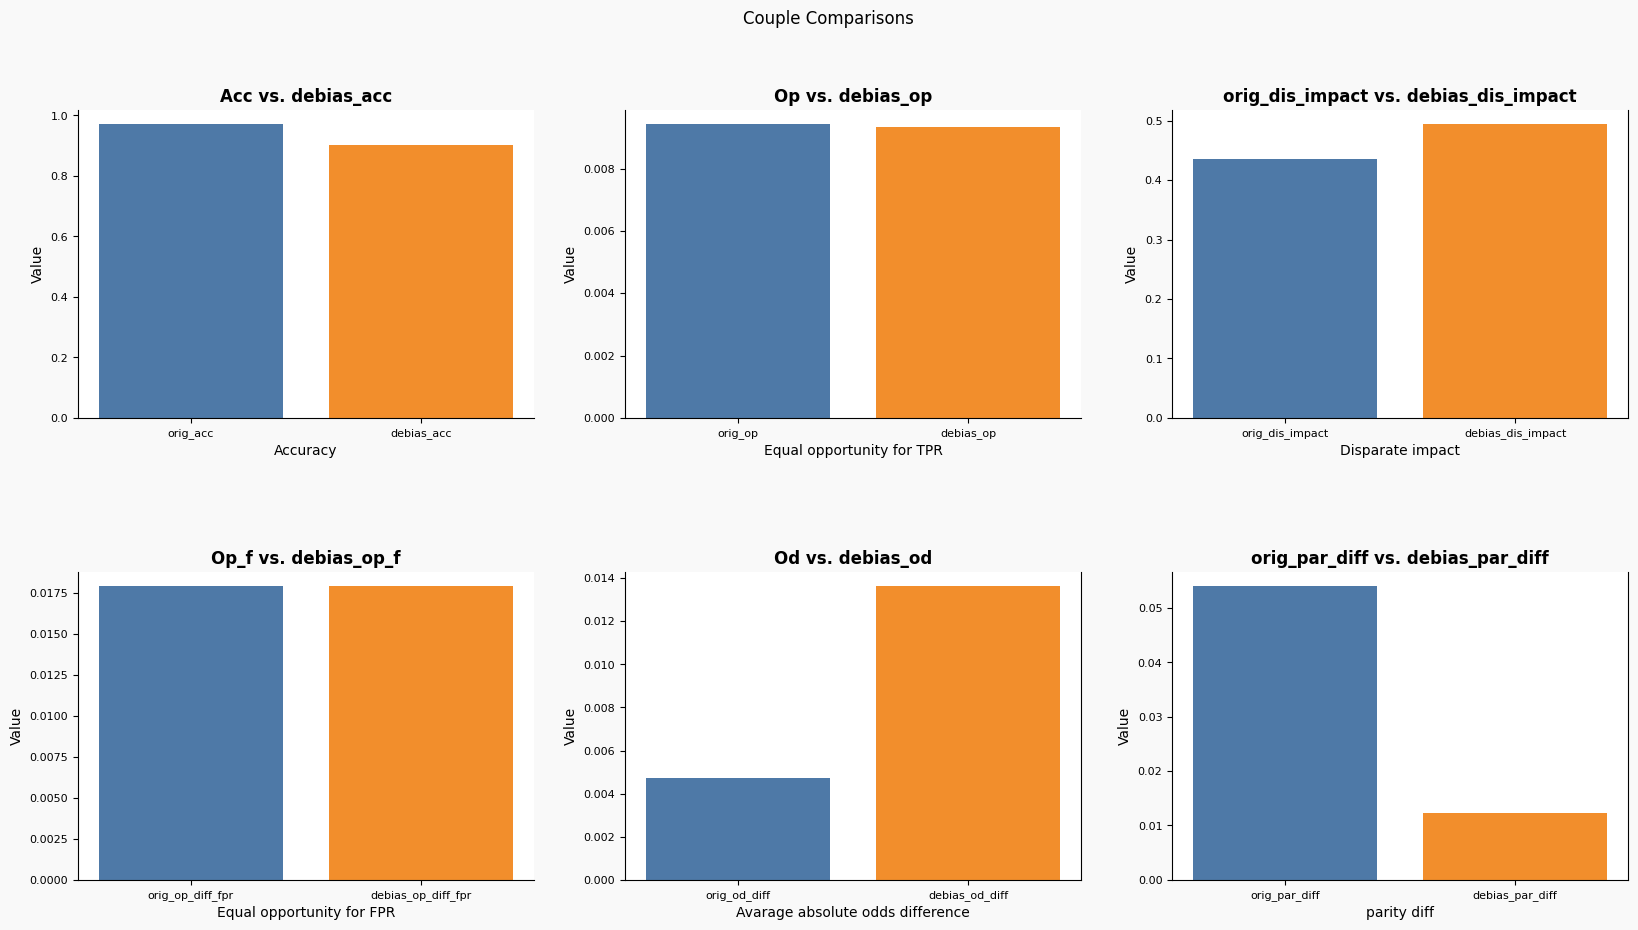

In [ ]:
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Initialize wandb
# wandb.init(project="couple-comparisons")

# Create a bar plot for each couple comparison
fig, ax = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Couple Comparisons')

# Set background color
fig.patch.set_facecolor('#f9f9f9')

# Acc vs. Pois_acc plot
ax[0, 0].bar(['orig_acc', 'debias_acc'], [mean(orig_acc), mean(upsampled_acc)], color=['#4e79a7', '#f28e2c'])
ax[0, 0].set_title('Acc vs. debias_acc', fontsize=12, fontweight='bold')
ax[0, 0].set_xlabel('Accuracy', fontsize=10)
ax[0, 0].set_ylabel('Value', fontsize=10)
ax[0, 0].tick_params(axis='both', which='major', labelsize=8)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)

# Op vs. Pois_op plot
ax[0, 1].bar(['orig_op','debias_op'], [mean(orig_op_diff), mean(upsampled_op_diff)], color=['#4e79a7', '#f28e2c'])
ax[0, 1].set_title('Op vs. debias_op', fontsize=12, fontweight='bold')
ax[0, 1].set_xlabel('Equal opportunity for TPR', fontsize=10)
ax[0, 1].set_ylabel('Value', fontsize=10)
ax[0, 1].tick_params(axis='both', which='major', labelsize=8)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

# Op_f vs. Pois_op_f plotdebias
ax[1, 0].bar(['orig_op_diff_fpr', 'debias_op_diff_fpr'], [mean(upsampled_op_diff_fpr), mean(upsampled_op_diff_fpr)], color=['#4e79a7', '#f28e2c'])
ax[1, 0].set_title('Op_f vs. debias_op_f', fontsize=12, fontweight='bold')
ax[1, 0].set_xlabel('Equal opportunity for FPR', fontsize=10)
ax[1, 0].set_ylabel('Value', fontsize=10)
ax[1, 0].tick_params(axis='both', which='major', labelsize=8)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)

# Od vs. Pois_od plot
ax[1, 1].bar(['orig_od_diff', 'debias_od_diff'], [mean(orig_od_diff), mean(upsampled_od_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 1].set_title('Od vs. debias_od', fontsize=12, fontweight='bold')
ax[1, 1].set_xlabel('Avarage absolute odds difference', fontsize=10)
ax[1, 1].set_ylabel('Value', fontsize=10)
ax[1, 1].tick_params(axis='both', which='major', labelsize=8)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines

# Od vs. Pois_od plot
ax[1, 2].bar(['orig_par_diff', 'debias_par_diff'], [mean(orig_par_diff), mean(upsampled_par_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 2].set_title('orig_par_diff vs. debias_par_diff', fontsize=12, fontweight='bold')
ax[1, 2].set_xlabel('parity diff', fontsize=10)
ax[1, 2].set_ylabel('Value', fontsize=10)
ax[1, 2].tick_params(axis='both', which='major', labelsize=8)
ax[1, 2].spines['top'].set_visible(False)
ax[1, 2].spines

# Od vs. Pois_od plot
ax[0, 2].bar(['orig_dis_impact', 'debias_dis_impact'], [mean(orig_dis_impact), mean(upsampled_dis_impact)], color=['#4e79a7', '#f28e2c'])
ax[0, 2].set_title('orig_dis_impact vs. debias_dis_impact', fontsize=12, fontweight='bold')
ax[0, 2].set_xlabel('Disparate impact', fontsize=10)
ax[0, 2].set_ylabel('Value', fontsize=10)
ax[0, 2].tick_params(axis='both', which='major', labelsize=8)
ax[0, 2].spines['top'].set_visible(False)
ax[0, 2].spines


In [ ]:
# X_train, y_train = df.loc[:, df.columns != 'Probability'], df['Probability']
# X_test , y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']

# clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR

# print("recall :", measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'recall'))
# print("far :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'far'))
# print("precision :", measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'precision'))
# print("accuracy :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'accuracy'))
# print("F1 Score :",measure_final_score(dataset_orig_tesst, clf, X_train, y_train, X_test, y_test, protected_attribute, 'F1'))
# print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
# print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))

# print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
# print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

# Verification

In [ ]:
# first one is class value and second one is protected attribute value
zero_zero = len(Upsampled_Dataset[(Upsampled_Dataset[TARGET_COL] == 0) & (Upsampled_Dataset[PRIV_FEATURE] == 0)])
zero_one = len(Upsampled_Dataset[(Upsampled_Dataset[TARGET_COL] == 0) & (Upsampled_Dataset[PRIV_FEATURE] == 1)])
one_zero = len(Upsampled_Dataset[(Upsampled_Dataset[TARGET_COL] == 1) & (Upsampled_Dataset[PRIV_FEATURE] == 0)])
one_one = len(Upsampled_Dataset[(Upsampled_Dataset[TARGET_COL] == 1) & (Upsampled_Dataset[PRIV_FEATURE] == 1)])

print(zero_zero,zero_one,one_zero,one_one)

54091 54091 54091 54091


In [ ]:
# Record the end time
end_time = time.time()

In [ ]:
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.4f} minutes")

Elapsed time: 9.6110 minutes
